In [1]:
# 1. Імпорти та налаштування середовища
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [2]:
# 2. Підготовка даних

# Трансформації
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2470, 0.2435, 0.2616))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2470, 0.2435, 0.2616))
])

# Завантаження датасету
root_dir = 'Intelligent-Computation\Lab3\cifar10'  # шлях до папки cifar10 з підпапками train/ та test/
full_train = datasets.CIFAR10(root=root_dir, train=True, download=True, transform=train_transform)
test_set   = datasets.CIFAR10(root=root_dir, train=False, download=True, transform=test_transform)

# Спліт на train/val
val_ratio = 0.2
val_size  = int(len(full_train) * val_ratio)
train_size = len(full_train) - val_size
train_set, val_set = random_split(full_train, [train_size, val_size])

# DataLoader-и
batch_size = 64
data_loaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2),
    'val':   DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=2),
    'test':  DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=2)
}

print(f"Sizes: train={train_size}, val={val_size}, test={len(test_set)}")

<>:18: SyntaxWarning: invalid escape sequence '\L'
<>:18: SyntaxWarning: invalid escape sequence '\L'
C:\Users\Artem\AppData\Local\Temp\ipykernel_19444\4012989910.py:18: SyntaxWarning: invalid escape sequence '\L'
  root_dir = 'Intelligent-Computation\Lab3\cifar10'  # шлях до папки cifar10 з підпапками train/ та test/


Files already downloaded and verified
Files already downloaded and verified
Sizes: train=40000, val=10000, test=10000


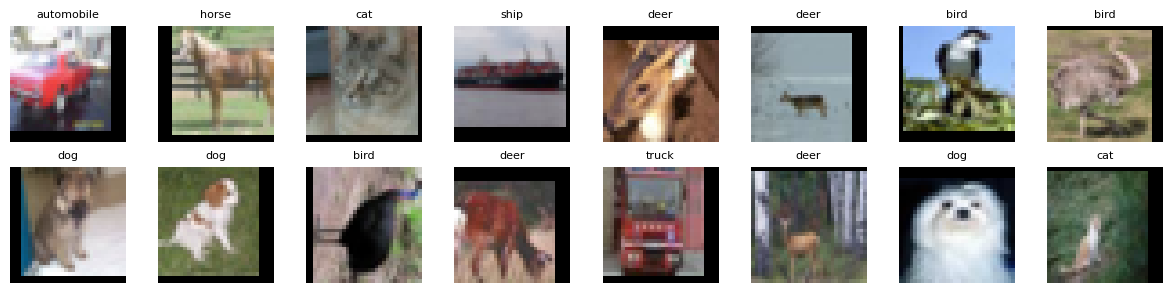

In [3]:
# 3. Візуалізація прикладів вибірки
%matplotlib inline
classes = full_train.classes

import numpy as np

# Правильне відновлення зображень після Normalize
mean = torch.tensor((0.4914, 0.4822, 0.4465)).view(3,1,1).to(device)
std  = torch.tensor((0.2470, 0.2435, 0.2616)).view(3,1,1).to(device)

# Отримуємо батч для візуалізації
dataiter = iter(data_loaders['train'])
images, labels = next(dataiter)

# Відобразимо 16 прикладів із підписами
rows, cols = 2, 8
fig, axes = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
for idx in range(rows*cols):
    ax = axes[idx//cols, idx%cols]
    img = images[idx].to(device)
    # денормалізація
    img = img * std + mean
    npimg = img.cpu().numpy().transpose((1, 2, 0))
    ax.imshow(np.clip(npimg, 0, 1))
    ax.set_title(classes[labels[idx]], fontsize=8)
    ax.axis('off')
plt.tight_layout()

In [4]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, features_channels=None, additional_block=False, activation=nn.ReLU, conv_dropout=0.0):
        super(SimpleCNN, self).__init__()
        # Налаштування каналів за замовчуванням
        if features_channels is None:
            features_channels = [32, 64, 128]
        layers = []
        in_ch = 3
        # Побудова послідовності згорткових блоків
        for out_ch in features_channels:
            layers.append(nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_ch))
            layers.append(activation(inplace=True))
            if conv_dropout > 0:
                layers.append(nn.Dropout2d(conv_dropout))
            layers.append(nn.MaxPool2d(2))
            in_ch = out_ch
        # Додатковий блок, якщо вказано
        if additional_block:
            layers.append(nn.Conv2d(in_ch, in_ch*2, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(in_ch*2))
            layers.append(activation(inplace=True))
            layers.append(nn.MaxPool2d(2))
            in_ch = in_ch * 2

        self.features = nn.Sequential(*layers)

        # Розрахунок розміру виходу після всіх MaxPool для динамічного визначення лінійного шару
        num_pools = len(features_channels) + (1 if additional_block else 0)
        spatial_size = 32 // (2 ** num_pools)
        self.flattened_size = in_ch * spatial_size * spatial_size

        # Класифікаційна частина
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, 256),
            activation(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Ініціалізація моделі
model = SimpleCNN().to(device)
print(model)


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=256, bias=T

In [5]:
# 5. Налаштування критерію та оптимізатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
# 6. Функції тренування та валідації

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(targets).sum().item()
        total += targets.size(0)

    return running_loss/total, correct/total


def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)

    return running_loss/total, correct/total

In [7]:
# 7. Тренування та валідація моделі
num_epochs = 20
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_one_epoch(model, data_loaders['train'], criterion, optimizer)
    val_loss, val_acc     = validate(model, data_loaders['val'], criterion)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print(f"Epoch {epoch}: TL={train_loss:.4f}, TA={train_acc:.4f}, VL={val_loss:.4f}, VA={val_acc:.4f}")

Epoch 1: TL=1.6643, TA=0.3774, VL=1.3806, VA=0.4901
Epoch 2: TL=1.3635, TA=0.4985, VL=1.2449, VA=0.5454
Epoch 3: TL=1.2292, TA=0.5585, VL=1.0494, VA=0.6154
Epoch 4: TL=1.1317, TA=0.5981, VL=1.0174, VA=0.6501
Epoch 5: TL=1.0738, TA=0.6221, VL=0.9241, VA=0.6678
Epoch 6: TL=1.0086, TA=0.6434, VL=0.8542, VA=0.6967
Epoch 7: TL=0.9718, TA=0.6601, VL=0.8655, VA=0.6955
Epoch 8: TL=0.9352, TA=0.6722, VL=0.8154, VA=0.7050
Epoch 9: TL=0.9002, TA=0.6875, VL=0.8014, VA=0.7161
Epoch 10: TL=0.8732, TA=0.6989, VL=0.7436, VA=0.7377
Epoch 11: TL=0.8373, TA=0.7093, VL=0.8131, VA=0.7236
Epoch 12: TL=0.8299, TA=0.7136, VL=0.7132, VA=0.7519
Epoch 13: TL=0.7969, TA=0.7262, VL=0.6807, VA=0.7640
Epoch 14: TL=0.7848, TA=0.7311, VL=0.7267, VA=0.7547
Epoch 15: TL=0.7620, TA=0.7398, VL=0.6759, VA=0.7666
Epoch 16: TL=0.7402, TA=0.7471, VL=0.6663, VA=0.7698
Epoch 17: TL=0.7336, TA=0.7480, VL=0.6418, VA=0.7803
Epoch 18: TL=0.7064, TA=0.7575, VL=0.6480, VA=0.7777
Epoch 19: TL=0.7018, TA=0.7605, VL=0.6298, VA=0.7821
Ep

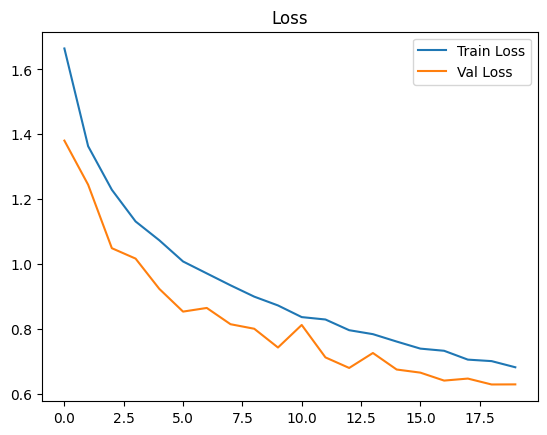

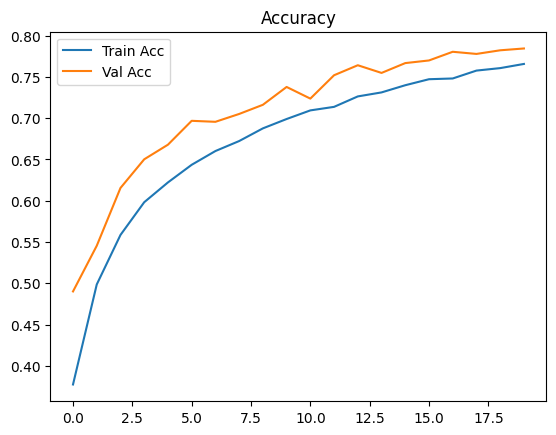

In [8]:
# 8. Візуалізація кривих навчання
plt.figure()
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.figure()
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

In [9]:
# 9. Оцінка на тестовому наборі
test_loss, test_acc = validate(model, data_loaders['test'], criterion)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Test Loss: 0.5936, Test Acc: 0.7999


Classification Report:
              precision    recall  f1-score   support

    airplane       0.75      0.85      0.79      1000
  automobile       0.90      0.92      0.91      1000
        bird       0.76      0.67      0.71      1000
         cat       0.63      0.64      0.64      1000
        deer       0.83      0.75      0.79      1000
         dog       0.75      0.69      0.72      1000
        frog       0.80      0.89      0.84      1000
       horse       0.89      0.79      0.84      1000
        ship       0.87      0.90      0.89      1000
       truck       0.83      0.90      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



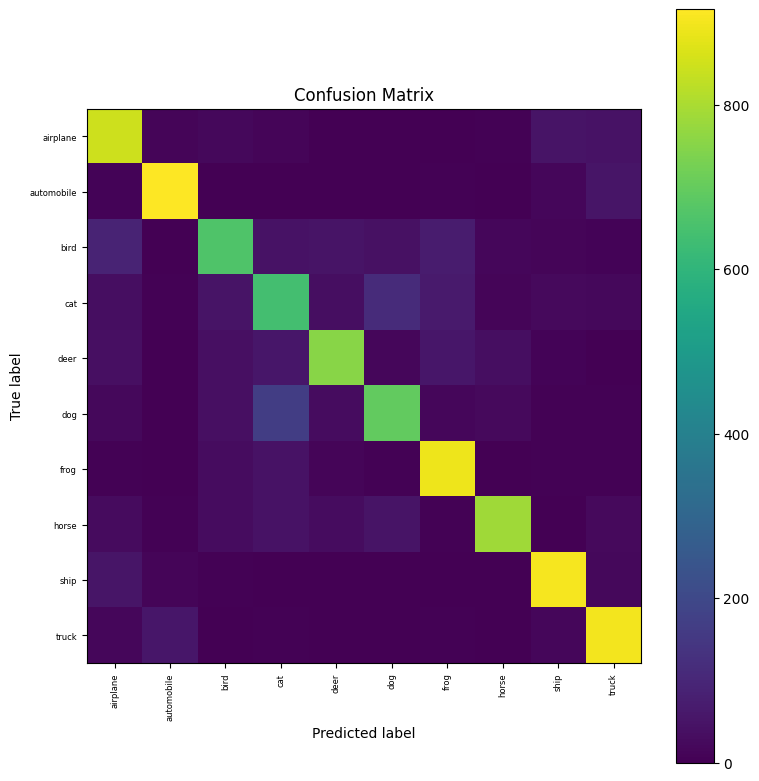

In [10]:
# 10. Детальний аналіз результатів

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Збирання прогнозів та міток
all_preds = []
all_targets = []
model.eval()
with torch.no_grad():
    for inputs, targets in data_loaders['test']:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(targets.numpy())

# Класифікаційний звіт
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=classes))

# Матриця невідповідностей
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90, fontsize=6)
plt.yticks(tick_marks, classes, fontsize=6)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

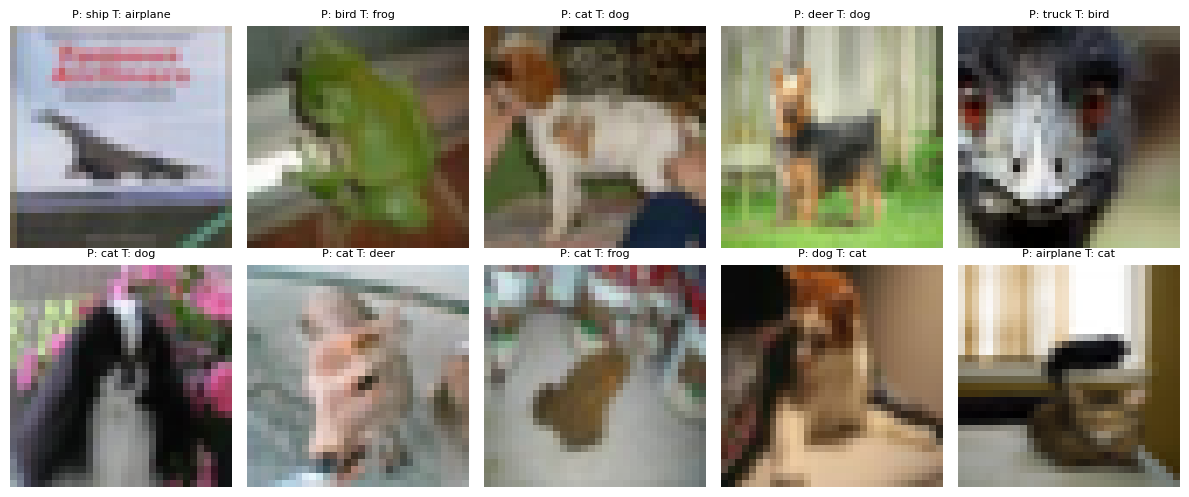

In [11]:
# 11. Приклади неправильних класифікацій
misclassified = []
model.eval()
with torch.no_grad():
    for inputs, targets in data_loaders['test']:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        for img, pred, true in zip(inputs, preds, targets):
            if pred != true and len(misclassified) < 10:
                misclassified.append((img, pred.item(), true.item()))

# Постобробка і візуалізація
# Повторно визначаємо mean та std для денормалізації
mean = torch.tensor((0.4914, 0.4822, 0.4465)).view(3,1,1).to(device)
std  = torch.tensor((0.2470, 0.2435, 0.2616)).view(3,1,1).to(device)
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for idx, (img, pred, true) in enumerate(misclassified):
    ax = axes[idx//5, idx%5]
    # денормалізація
    img = img * std + mean
    npimg = img.cpu().numpy().transpose((1, 2, 0))
    ax.imshow(np.clip(npimg, 0, 1))
    ax.set_title(f"P: {classes[pred]} T: {classes[true]}", fontsize=8)
    ax.axis('off')
plt.tight_layout()
plt.show()

# 12. Серія експериментів

Ми проведемо кілька варіантів моделі, щоб подивитися вплив архітектури на якість та час тренування:
- **baseline**: SimpleCNN (3 Conv-блоки 32→64→128 + FC)
- **exp1**: збільшена ширина (64→128→256)
- **exp2**: додатковий Conv-блок (32→64→128→256)
- **exp3**: зміна активації на LeakyReLU
- **exp4**: додатковий Dropout (p=0.3) у Conv-блоках

In [12]:
from time import time
import pandas as pd

# Функції для створення моделей
from functools import partial

model_fns = {
    'baseline': SimpleCNN,
    'exp1': lambda: SimpleCNN(features_channels=[64,128,256]),
    'exp2': lambda: SimpleCNN(additional_block=True),
    'exp3': lambda: SimpleCNN(activation=nn.LeakyReLU),
    'exp4': lambda: SimpleCNN(conv_dropout=0.3)
}

results = []

for name, fn in model_fns.items():
    model = fn().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    start = time()
    # тренуємо 10 епох
    for epoch in range(1, 11):
        train_one_epoch(model, data_loaders['train'], criterion, optimizer)
        validate(model, data_loaders['val'], criterion)
    duration = time() - start
    test_loss, test_acc = validate(model, data_loaders['test'], criterion)
    results.append({'model': name, 'test_acc': test_acc, 'time_s': duration})

# Вивід результатів
df_results = pd.DataFrame(results)
print(df_results)


      model  test_acc      time_s
0  baseline    0.7514  186.392693
1      exp1    0.7546  191.964512
2      exp2    0.7790  195.758053
3      exp3    0.7675  194.826664
4      exp4    0.6321  195.236952


# 13. Порівняння (Ablation Study)

```python
# plt.barh(df_results['model'], df_results['test_acc'])
# plt.xlabel('Test Accuracy')
# plt.title('Model Comparison')
# plt.show()
```

In [13]:
# Найкраща модель:
best = max(results, key=lambda x: x['test_acc'])
print(f"Найкраща: {best['model']} з точністю {best['test_acc']:.4f}")

Найкраща: exp2 з точністю 0.7790
